In [2]:
import os
from uuid import uuid4

import alpha_clip
import numpy as np
import polars as pl
import torch
from PIL import Image
from qdrant_client import QdrantClient, models
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

client = QdrantClient(host="127.0.0.1", port=6333)
# client.create_collection(
#     collection_name="crossgeo-mp16reason",
#     vectors_config=models.VectorParams(size=768, distance=models.Distance.COSINE),
# )


In [3]:
# ADE20K semantic segmentation model
model_name = "facebook/mask2former-swin-large-ade-semantic"

processor = AutoImageProcessor.from_pretrained(model_name)
model = Mask2FormerForUniversalSegmentation.from_pretrained(model_name).to(device)
model = model.eval()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/home/affahrizain/project/affandy-fahrizain/.venv/lib/python3.11/site-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


In [4]:
class ImageDataset(Dataset):
    def __init__(
        self,
        df: pl.DataFrame,
        img_col: str = "IMG_ID",
        img_base_path: str = "",
    ):
        self.df = df
        self.img_col = img_col
        self.img_base_path = img_base_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        df_batch = self.df[index]
        path = df_batch[self.img_col].item()
        path = os.path.join(self.img_base_path, path)

        img = Image.open(path).convert("RGB")
        # target_sizes expects (height, width)
        size = img.size[::-1]

        return {"image": img, "size": size}


def collate_fn(batch):
    images = [b["image"] for b in batch]
    sizes = [b["size"] for b in batch]
    inputs = processor(images=images, return_tensors="pt")
    return inputs, sizes, images

In [5]:
class FeatureExtractor(nn.Module):
    def __init__(
        self,
        alpha_clip_name: str = "ViT-L/14",
        mask_model_name: str = "facebook/mask2former-swin-large-ade-semantic",
        alpha_vision_ckpt_pth: str = "../checkpoints/clip_l14_grit20m_fultune_2xe.pth",
        device: str = "cuda",
    ):
        super().__init__()

        self.device = device
        with torch.autocast(self.device, dtype=torch.bfloat16):
            self.mask_processor = AutoImageProcessor.from_pretrained(mask_model_name)
            self.mask_model = Mask2FormerForUniversalSegmentation.from_pretrained(
                mask_model_name
            ).to(device)
            self.mask_model = self.mask_model.eval()

        self.alphaclip_model, self.alphaclip_processor = alpha_clip.load(
            alpha_clip_name, alpha_vision_ckpt_pth=alpha_vision_ckpt_pth, device=device
        )
        transform_size = 336 if model_name == "ViT-L/14@336px" else 224
        self.mask_transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((transform_size, transform_size)),
                transforms.Normalize(0.5, 0.26),
            ]
        )

    @torch.no_grad
    def forward(
        self, batch_inputs: torch.Tensor, images: list, target_sizes: torch.Tensor
    ):
        # mask generation
        batch_inputs = {k: v.to(device) for k, v in batch_inputs.items()}

        with torch.autocast(self.device, dtype=torch.bfloat16):
            outputs = self.mask_model(**batch_inputs)

        segs = self.mask_processor.post_process_semantic_segmentation(
            outputs, target_sizes=target_sizes
        )

        alpha_embeddings = []
        all_masks = []
        all_labels = []
        for seg, img in zip(segs, images):
            seg_np = seg.cpu().numpy().astype(np.int32)
            mask_indices = np.unique(seg_np)
            alpha = []
            masks = []
            labels = []
            for label in mask_indices:
                mask = seg_np == label
                mask = (mask * 255).astype(np.uint8)
                masks.append(mask)
                mask = self.mask_transform(mask)
                alpha.append(mask)
                # img_mask.append((mask * 255).astype(np.uint8))
                labels.append(model.config.id2label[label])
            all_masks.append(masks)
            all_labels.append(labels)

            # mask embedding
            alpha = torch.stack(alpha).half().to(self.device)
            alpha_img_processed = (
                self.alphaclip_processor(img).unsqueeze(0).half().to(self.device)
            )
            alpha_out = (
                self.alphaclip_model.visual(alpha_img_processed, alpha).cpu().numpy()
            )
            alpha_embeddings.append(alpha_out)

            del alpha_out

        del outputs
        del segs
        torch.cuda.empty_cache()

        return {
            "alpha_embeddings": alpha_embeddings,
            "masks": all_masks,
            "labels": all_labels,
            "images": [np.array(img) for img in images],
        }

In [6]:
extractor = FeatureExtractor()

### Ingest to VectorDB

In [6]:
df = pl.read_csv("../datasets/mp16-reason/mp16-reason-train.csv")
dataset = ImageDataset(
    df,
    img_col="IMG_ID",
    img_base_path="../datasets/mp16-reason/mp16-reason-train",
)
loader = DataLoader(dataset, batch_size=128, collate_fn=collate_fn)

In [7]:
all_outputs = {}
for batch, target, images in tqdm(loader, desc="Mask"):
    out = extractor(batch, images, target)
    for key, val in out.items():
        if key not in all_outputs:
            all_outputs[key] = val
        else:
            all_outputs[key].extend(val)

Mask: 100%|██████████| 264/264 [23:55<00:00,  5.44s/it]


In [16]:
all_outputs.keys()

dict_keys(['alpha_embeddings', 'masks', 'labels', 'images'])

In [ ]:
import base64

for i in tqdm(range(len(df)), desc="ingest"):
    meta = df[i].to_dict(as_series=False)
    # meta["masks"] = [m.tolist() for m in all_outputs["masks"][i]]
    # meta["labels"] = all_outputs["labels"][i]
    meta["image"] = base64.b64encode(
        Image.fromarray(all_outputs["images"][i]).tobytes()
    ).decode("utf-8")
    meta["index"] = i

    qdrant_points = []
    for sidx, (embed, mask) in tqdm(
        enumerate(zip(all_outputs["alpha_embeddings"][i], all_outputs["masks"][i])),
        desc="batch pack",
        leave=False,
    ):
        meta["segment_id"] = sidx
        meta["segment_mask"] = mask.tolist()
        meta["segment_mask_img"] = base64.b64encode(
            Image.fromarray(mask).tobytes()
        ).decode("utf-8")
        qdrant_points.append(models.PointStruct(id=uuid4(), vector=embed, payload=meta))

    client.upsert(collection_name="crossgeo-mp16reason", points=qdrant_points)

ingest: 100%|██████████| 33721/33721 [2:32:24<00:00,  3.69it/s]  


### Retrieval Inference

In [12]:
df_ref = pl.read_csv("../datasets/mp16-reason/mp16-reason-train.csv")

In [7]:
# retrieval inference
query_img = Image.open("Tokyo_Skytree_2014.jpg")
query_img_size = [query_img.size[::-1]]
query_input = extractor.mask_processor(images=query_img, return_tensors="pt")
query_input["pixel_values"].shape

torch.Size([1, 3, 384, 384])

In [8]:
query_embed = extractor(query_input, [query_img], query_img_size)

In [9]:
search_queries = [
    models.QueryRequest(query=embed, limit=10, with_payload=True)
    for embed in query_embed["alpha_embeddings"][0]
]

query_res = client.query_batch_points(
    collection_name="crossgeo-mp16reason", requests=search_queries
)

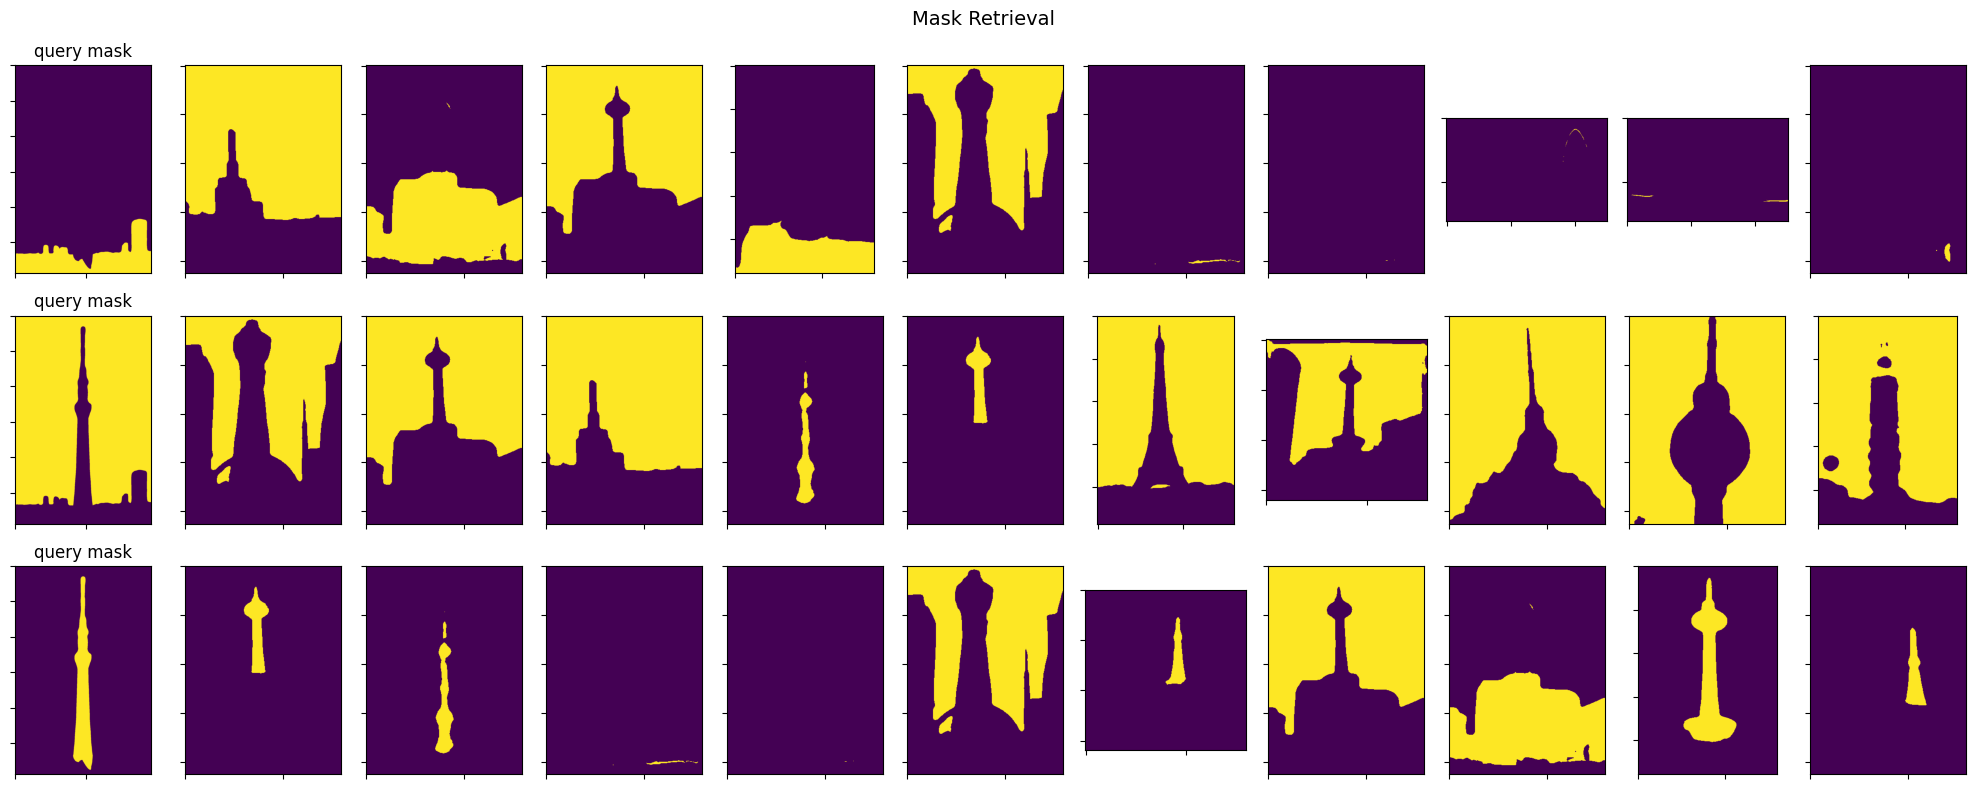

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(query_res), 11, figsize=(20, 8))
for i in range(len(query_res)):
    qres = query_res[i].points
    for j in range(11):
        if j == 0:
            ax[i, j].set_title("query mask")
            ax[i, j].imshow(Image.fromarray(query_embed["masks"][0][i]))
        else:
            res_mask = np.array(qres[(j - 1)].payload["segment_mask"]).astype(np.uint8)
            ax[i, j].imshow(Image.fromarray(res_mask))
        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])

fig.suptitle("Mask Retrieval", fontsize=14)
plt.tight_layout()
plt.savefig("./segment-retrieval-mask.png")
plt.show()

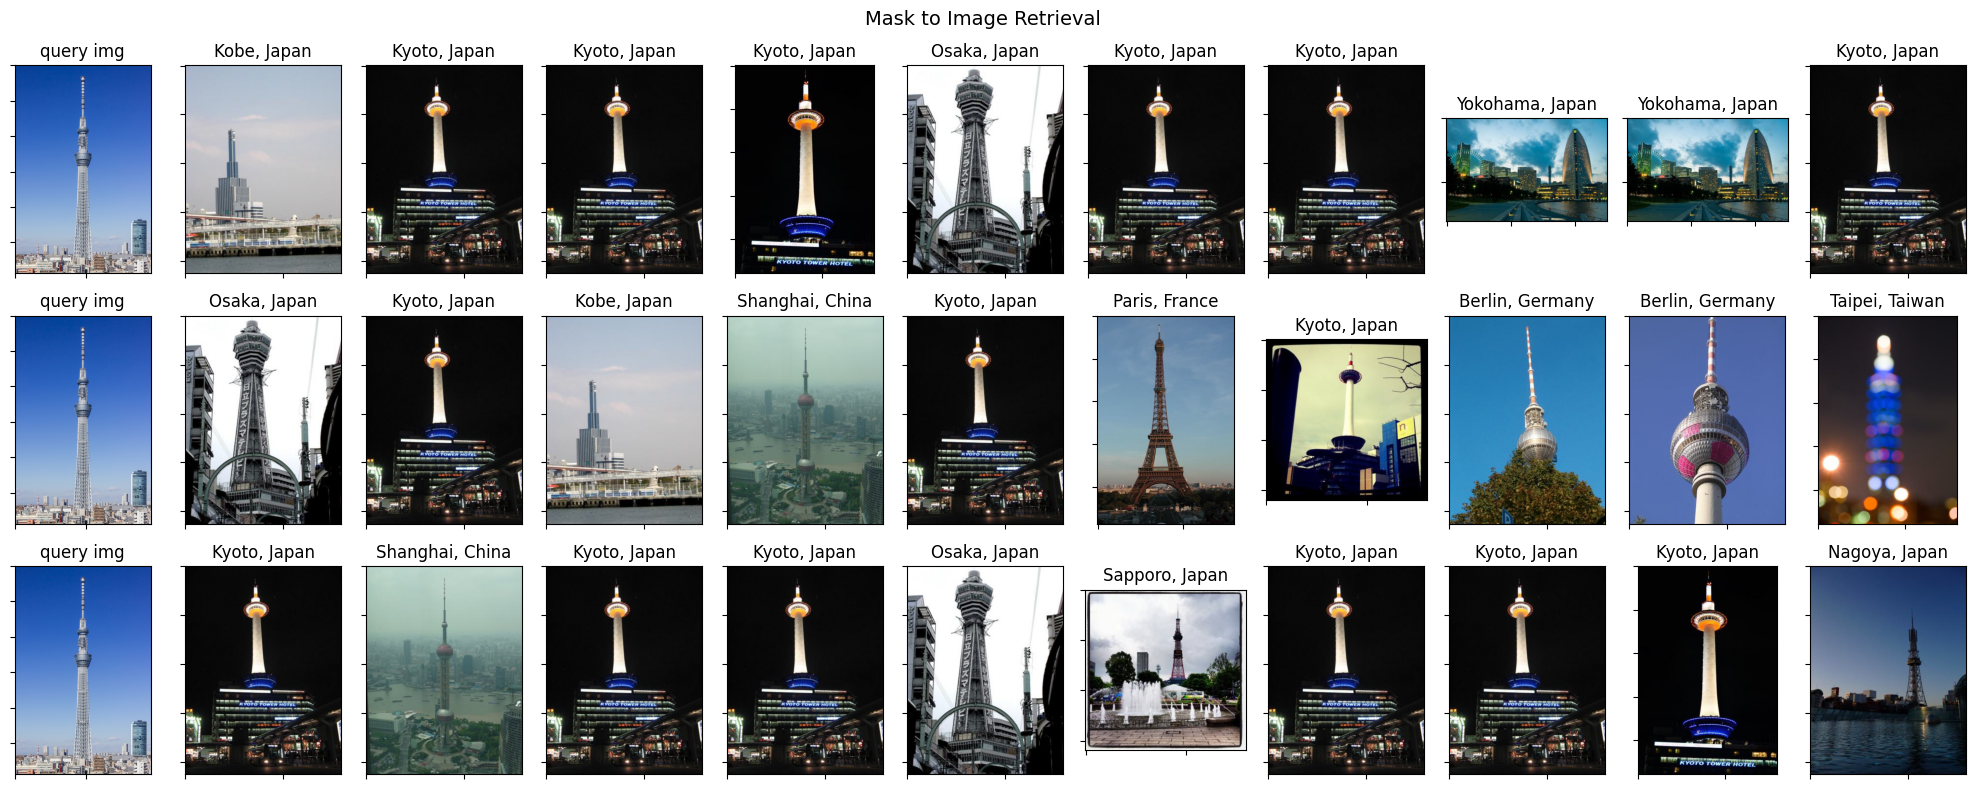

In [13]:
fig, ax = plt.subplots(len(query_res), 11, figsize=(20, 8))
for i in range(len(query_res)):
    qres = query_res[i].points
    for j in range(11):
        if j == 0:
            ax[i, j].set_title("query img")
            ax[i, j].imshow(query_img)
        else:
            df_id = qres[(j - 1)].payload["index"]
            gt_data = df_ref[df_id].to_dict(as_series=False)
            ax[i, j].imshow(
                Image.open(
                    os.path.join(
                        "../datasets/mp16-reason/mp16-reason-train",
                        gt_data["IMG_ID"][0],
                    )
                )
            )
            ax[i, j].set_title(", ".join([gt_data["city"][0], gt_data["country"][0]]))
        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])

fig.suptitle("Mask to Image Retrieval", fontsize=14)
plt.tight_layout()
# plt.savefig("./segment-retrieval-img.png")
plt.show()

In [25]:
merged_response = [item.payload for qres in query_res for item in qres.points]

In [28]:
merged_response = {}

for qres in query_res:
    for item in qres.points:
        payload = item.payload
        if payload["index"] not in merged_response:
            merged_response[payload["index"]] = payload

In [ ]:
merged_response = list(merged_response.values())
id_responses = [d["index"] for d in merged_response]
gps_responses = df_ref[id_responses][:, ["LAT", "LON"]].to_numpy()

In [ ]:
import sys

sys.path.append("..")
from src.utils import haversine

gt_gps = np.array((35.710056, 139.810722))
distances = haversine(gt_gps, gps_responses)
rank_desc = np.argsort(distances)[::-1]

In [ ]:
reranked_response = [
    {**merged_response[i], "distance": distances[i].item()} for i in rank_desc
]

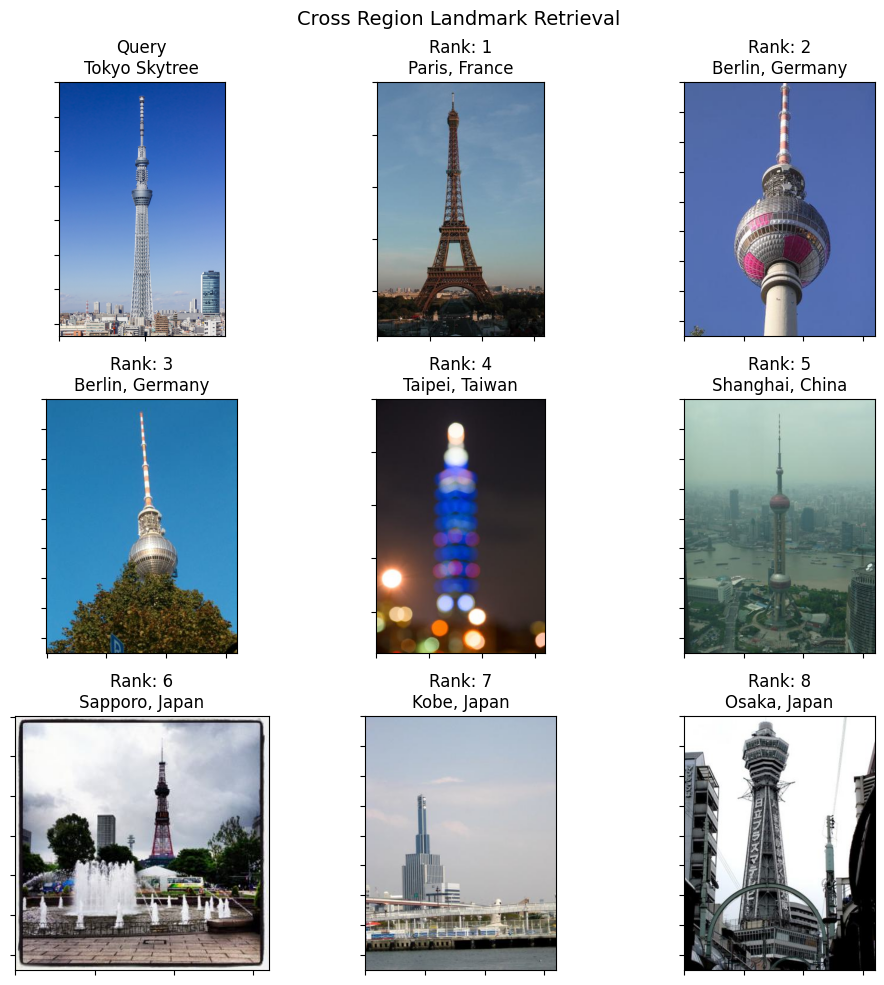

In [87]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        if i == 0 and j == 0:
            ax[i, j].set_title("Query\nTokyo Skytree")
            ax[i, j].imshow(query_img)
        else:
            idx = (i * 3 + (j-1))
            res = reranked_response[idx]
            ax[i, j].imshow(
                Image.open(
                    os.path.join(
                        "../datasets/mp16-reason/mp16-reason-train", res["IMG_ID"][0]
                    )
                )
            )
            ax[i, j].set_title(f"Rank: {idx+1}\n" + ", ".join([res["city"][0], res["country"][0]]))
        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])

fig.suptitle("Cross Region Landmark Retrieval", fontsize=14)
plt.tight_layout()
plt.savefig("retrieval-result-final.png")
plt.show()

In [ ]:
from io import BytesIO
import numpy as np
from base64 import b64decode, b64encode
from PIL import Image

img = Image.open("./Tokyo_Skytree_2014.jpg").convert("RGB")
buff = BytesIO(b64decode(b64encode(Image.fromarray(np.array(img)).tobytes()).decode("utf-8")))
Image.open(buff)

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x762a8c64b6f0>